# PyTorch Tester
Test if PyTorch was installed correctly, and if CUDA devices are available

In [1]:

import torch
x = torch.rand(5, 3)
print(x)
torch.cuda.is_available()


tensor([[0.1338, 0.9017, 0.2004],
        [0.0978, 0.3711, 0.3531],
        [0.7188, 0.7160, 0.8460],
        [0.2020, 0.4699, 0.4234],
        [0.1393, 0.0069, 0.8074]])


True

In [2]:
from d2l import torch as d2l
from torch.nn import functional as F
from torch import nn
import torchvision
import torch
import os
import random
import numpy as np
import torch.optim as optim
from torchvision import transforms
from PIL import Image, ImageDraw
from IPython.display import display


%matplotlib inline


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)


In [3]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)


In [4]:
def forward(x, block):
    return block(x)


Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape


(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [5]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)


def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)


In [6]:
concat_preds([Y1, Y2]).shape


torch.Size([2, 25300])

In [7]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)


In [8]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape


torch.Size([2, 10, 10, 10])

In [9]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)


forward(torch.zeros((2, 3, 256, 256)), base_net()).shape


torch.Size([2, 64, 32, 32])

In [10]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk


In [11]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)


In [12]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)


forward(torch.zeros((2, 3, 256, 256)), base_net()).shape


torch.Size([2, 64, 32, 32])

In [13]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1


In [14]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds


In [15]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)


output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [65]:
class RisikoDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir: str, mode: str, transform=None):
        if mode != "train" and mode != "val" and mode != "test":
            raise Exception("Mode value of dataset not valid")

        self.imgs_dir = dataset_dir + "/" + mode + "/images"
        self.annots_dir = dataset_dir + "/" + mode + "/labels"

        self.annotations = sorted(filter(lambda x: os.path.isfile(
            os.path.join(self.annots_dir, x)), os.listdir(self.annots_dir)))
        self.images = sorted(filter(lambda x: os.path.isfile(
            os.path.join(self.imgs_dir, x)), os.listdir(self.imgs_dir)))
        self.transform = transform

        if len(self.annotations) != len(self.images):
            raise Exception(
                "Number of annotations is different from the number of images")

        for i in range(len(self.annotations)):
            if os.path.splitext(os.path.basename(self.annotations[i]))[0] != os.path.splitext(os.path.basename(self.images[i]))[0]:
                raise Exception("Mismatch between images and annotations at id " + str(i) + ".   imgName = " + os.path.splitext(
                    os.path.basename(self.images[i]))[0] + "   labelName = " + os.path.splitext(os.path.basename(self.annotations[i]))[0])

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        annotations_file_data = np.genfromtxt(
            fname=self.annots_dir + "/" + self.annotations[idx], delimiter=' ', dtype=np.float32)
        classes, bboxes = np.hsplit(annotations_file_data, np.array([1]))
        for i in range(bboxes.shape[0]):
            bbox = bboxes[i]

            x0 = bbox[0] - bbox[2] / 2
            x1 = bbox[0] + bbox[2] / 2
            y0 = bbox[1] - bbox[3] / 2
            y1 = bbox[1] + bbox[3] / 2
        bboxes = torch.tensor([x0, y0, x1, y1])

        #print((torch.from_numpy(classes).type(
        #    torch.IntTensor), torch.from_numpy(bboxes)))
        output_dict = torch.concat((torch.from_numpy(classes).type(
            torch.IntTensor), bboxes), 1)
        #print(output_dict)

        img = Image.open(self.imgs_dir + "/" + self.images[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return (img.float(), output_dict)


In [60]:
train_iter, _ = d2l.load_data_bananas(batch_size)


read 1000 training examples
read 100 validation examples


In [67]:
new_train_iter, new_val_iter= train_loader(batch_size)


In [ ]:
print("banana train")
print(train_iter)
for features, target in train_iter:
    print(features[0])
    print(target[0])
print("our train")
print(new_train_iter)
for features, target in new_train_iter:
    print(features)
    print(target)


banana train
tensor([[[ 20.,  21.,  22.,  ..., 186., 183., 182.],
         [ 26.,  22.,  21.,  ..., 187., 186., 183.],
         [ 21.,  17.,  18.,  ..., 188., 186., 185.],
         ...,
         [166., 139., 155.,  ...,  80.,  70.,  17.],
         [111., 123., 128.,  ...,  50.,  62.,  22.],
         [133., 150., 152.,  ...,  18.,  24.,  22.]],

        [[ 27.,  26.,  23.,  ..., 248., 247., 246.],
         [ 32.,  28.,  25.,  ..., 249., 247., 247.],
         [ 29.,  26.,  27.,  ..., 250., 247., 246.],
         ...,
         [153., 124., 135.,  ..., 100.,  88.,  35.],
         [ 75.,  93., 109.,  ...,  68.,  77.,  37.],
         [ 85., 113., 133.,  ...,  35.,  38.,  36.]],

        [[ 20.,  22.,  27.,  ..., 245., 247., 248.],
         [ 28.,  26.,  26.,  ..., 246., 248., 249.],
         [ 31.,  25.,  22.,  ..., 249., 250., 251.],
         ...,
         [ 51.,  23.,  36.,  ...,  47.,  40.,   0.],
         [  0.,   7.,   7.,  ...,  30.,  44.,   4.],
         [ 21.,  35.,  30.,  ...,   3., 

/tmp/ipykernel_4520/160284762.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (img.float(), torch.tensor(output_dict))


tensor([[[[244., 243., 237.,  ..., 255., 255., 255.],
          [230., 230., 225.,  ..., 255., 255., 255.],
          [202., 203., 202.,  ..., 255., 255., 255.],
          ...,
          [ 71.,  71.,  70.,  ...,  50.,  49.,  49.],
          [ 75.,  76.,  73.,  ...,  46.,  44.,  44.],
          [ 77.,  77.,  75.,  ...,  42.,  39.,  38.]],

         [[242., 241., 235.,  ..., 255., 255., 255.],
          [228., 228., 223.,  ..., 255., 255., 255.],
          [200., 201., 200.,  ..., 255., 255., 255.],
          ...,
          [ 83.,  83.,  82.,  ...,  73.,  72.,  72.],
          [ 85.,  86.,  85.,  ...,  69.,  67.,  67.],
          [ 87.,  87.,  87.,  ...,  65.,  62.,  61.]],

         [[219., 218., 212.,  ..., 255., 255., 255.],
          [205., 205., 200.,  ..., 255., 255., 255.],
          [177., 178., 177.,  ..., 255., 255., 255.],
          ...,
          [ 73.,  73.,  72.,  ...,  45.,  44.,  44.],
          [ 76.,  77.,  75.,  ...,  41.,  39.,  39.],
          [ 78.,  78.,  77.,  ...

In [66]:


img_to_tensor = transforms.Compose([
    # transforms.Resize(size=(500,500)),
    transforms.PILToTensor()
])

batch_size = 1

dataset_path = "./data"

train_set = RisikoDataset(dataset_dir=dataset_path,
                          mode="train", transform=img_to_tensor)
val_set = RisikoDataset(dataset_dir=dataset_path,
                        mode="val", transform=img_to_tensor)
test_set = RisikoDataset(dataset_dir=dataset_path,
                         mode="test", transform=img_to_tensor)


def train_loader(batch_size):

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader


new_train_iter, _ = train_loader(batch_size)


In [24]:


def draw_bboxes_on_image(dataset: RisikoDataset, index: int):
    img, labels = dataset.__getitem__(index)
    tensor_to_img = transforms.Compose([transforms.ToPILImage()])
    img = tensor_to_img(img)
    bboxes: torch.Tensor = labels["boxes"]

    img_draw = ImageDraw.Draw(img)


#    bboxes = bboxes * torch.tensor([1280, 720, 1280, 720]) # this depends on image size, we might want to generalize this
    bboxes = bboxes * torch.tensor([1920, 1280, 1920, 1280])

    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]

        x0 = bbox[0] - bbox[2] / 2
        x1 = bbox[0] + bbox[2] / 2
        y0 = bbox[1] - bbox[3] / 2
        y1 = bbox[1] + bbox[3] / 2

        img_draw.rectangle([x0, y0, x1, y1], outline="red")

    display(img)


draw_bboxes_on_image(train_set, random.randint(0, len(train_set)-1))


(tensor([[ 5],
        [ 0],
        [ 2],
        [ 0],
        [ 6],
        [ 6],
        [ 6],
        [ 7],
        [ 9],
        [ 9],
        [ 6],
        [ 8],
        [10],
        [ 8],
        [ 6],
        [ 7],
        [ 6]], dtype=torch.int32), tensor([[0.5246, 0.7028, 0.0352, 0.0972],
        [0.4676, 0.7007, 0.0336, 0.0514],
        [0.5184, 0.5979, 0.0461, 0.0569],
        [0.5676, 0.3924, 0.0508, 0.0403],
        [0.3504, 0.6590, 0.0508, 0.0569],
        [0.4352, 0.9417, 0.0344, 0.0806],
        [0.6609, 0.5611, 0.0406, 0.0917],
        [0.5773, 0.7590, 0.0312, 0.0875],
        [0.7379, 0.2771, 0.0477, 0.0569],
        [0.7367, 0.3514, 0.0516, 0.0694],
        [0.6625, 0.4521, 0.0500, 0.0569],
        [0.5684, 0.7021, 0.0523, 0.0597],
        [0.6879, 0.5708, 0.0477, 0.0556],
        [0.2492, 0.4771, 0.0406, 0.0597],
        [0.5645, 0.6826, 0.0477, 0.0569],
        [0.5887, 0.4167, 0.0445, 0.0722],
        [0.5383, 0.2486, 0.0453, 0.0917]]))
tensor([[ 5.0000,  0.524

C:\Temp\ipykernel_15620\160284762.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (img.float(), torch.tensor(output_dict))


IndexError: too many indices for tensor of dimension 2

In [25]:
device, net = d2l.try_gpu(), TinySSD(num_classes=12)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)


In [26]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')


def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox


In [27]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())


def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

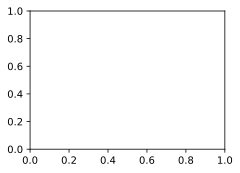

In [68]:
num_epochs, timer = 5, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in new_train_iter:
        timer.start()
        trainer.zero_grad()
        print("TARGET", target)
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        print("NET", (anchors, cls_preds, bbox_preds))
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        print("TARGET", bbox_labels, bbox_masks, cls_labels)
        input()
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,   
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(new_train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')
